In [4]:
#import necessary library and frame
import pandas as pd
import numpy as np
import tensorflow as tf
import re
# import sklearn method
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
#import keras method
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense,Bidirectional
#import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#import utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
#Load the data
Movie_df=pd.read_csv('IMDB Dataset.csv')
print('Shape of dataset::',Movie_df.shape)
Movie_df.head(10)

Shape of dataset:: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


General stats::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB
None
Summary stats::

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


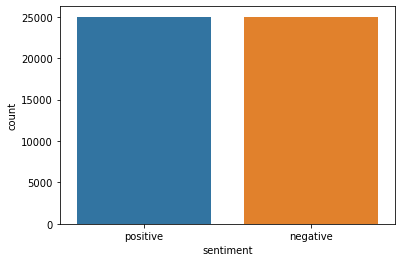

In [6]:
#positive and negative reviews
import seaborn as sns
sns.countplot(x='sentiment', data=Movie_df)

#Stats of our data
print("General stats::")
print(Movie_df.info())
print("Summary stats::\n")
print(Movie_df.describe())

In [7]:
#Number of poitive & negative reviews
Movie_df.sentiment.value_counts()

reviews=Movie_df['review']
sentiment=Movie_df['sentiment']
#Summarize no. of classes
print('Classes::\n',np.unique(sentiment))

Classes::
 ['negative' 'positive']


In [11]:
# Split the data into train & test datasets
train_reviews=reviews[:30000]
train_sentiment=sentiment[:30000]
test_reviews=reviews[30000:]
test_sentiment=sentiment[30000:]
# Shape of train & test dataset
# train_reviews, test_reviews, train_sentiment, test_sentiment = train_test_split(reviews.values, sentiment.values, test_size = 0.4, random_state=42)
print('Shape of train dataset::',train_reviews.shape,train_sentiment.shape)
print('Shape of test dataset::',test_reviews.shape,test_sentiment.shape)

Shape of train dataset:: (30000,) (30000,)
Shape of test dataset:: (20000,) (20000,)


In [12]:
#Encode our target labels
lb=preprocessing.LabelBinarizer()
#Encode 1 for positive label & 0 for Negative label
train_sentiment=lb.fit_transform(train_sentiment)
test_sentiment=lb.transform(test_sentiment)
#Reshape the array
train_sentiment=train_sentiment.ravel()  
test_sentiment=test_sentiment.ravel()
#Convert categoricals to numeric ones
train_sentiment=train_sentiment.astype('int64')
test_sentiment=test_sentiment.astype('int64')

In [13]:
#Let's explore our data before normalization
print(train_reviews[0])
# train_reviews[0]
# test_reviews[30001]

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [14]:
train_sentiment[0:10]


array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [15]:
test_sentiment[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [16]:
#Let's normalize our data to remove stopwords, html tags and so on.
ps=PorterStemmer()
stopwords=set(stopwords.words('english'))
# Define function for data mining
def normalize_reviews(review):
    #Excluding html tags
    data_tags=re.sub(r'<[^<>]+>'," ",review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',data_tags)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text

#Normalize the train & test data
norm_train_reviews=train_reviews.apply(normalize_reviews)
norm_test_reviews=test_reviews.apply(normalize_reviews)

In [17]:
#Let's look at our normalized data
norm_train_reviews[0]


'one review mention watch 1 oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort u

In [18]:
norm_test_reviews[30001]

'one silliest movi ever misfortun watch expect see first two keep get sucker type movi idea mayb right time nope even close begin special effect give idea pass sfx movi one point soldier shoot raptor run hallway even less second screen time viewer easili see man tail appar tape run around bad bad bad bad act that call one charact suppos suppos south howev live south six year never heard way talk perhap sort weird disabl inabl talk normal find fascin charact noth requir accent therefor reason actor tri one plot pretti basic raptor escap peopl gun must hunt im start wonder dinosaur movi alway seem run nearest system tunnel wouldnt stay outsid hunt prey oh well least good sens appear littl movi supposedli revolv around thing let say build know man eat raptor run around would decid take time argument better armi marin decid arm wrestl contest settl idiot idea track raptor split group two didnt ever watch horror movi least episod scoobi doo short one dumber movi miss unless want groan way m

In [19]:
#Let's create features using bag of words model
cv=CountVectorizer(ngram_range=(1,2))
train_cv=cv.fit_transform(norm_train_reviews)
test_cv =cv.transform(norm_test_reviews)
print('Shape of train_cv::',train_cv.shape)
print('Shape of test_cv::',test_cv.shape)

Shape of train_cv:: (30000, 1929440)
Shape of test_cv:: (20000, 1929440)


In [36]:
#Training the classifier
rfc=RandomForestClassifier(n_estimators=20,random_state=42)
rfc=rfc.fit(train_cv,train_sentiment)
score=rfc.score(train_cv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.9996


In [37]:
%%time
#Making predicitions
rfc_predict=rfc.predict(test_cv)

CPU times: user 1.31 s, sys: 0 ns, total: 1.31 s
Wall time: 1.31 s


In [38]:
#How accuate our model is?
cm=confusion_matrix(test_sentiment,rfc_predict)
cm

array([[8291, 1724],
       [2093, 7892]])

In [39]:
#print classification report for performance metrics
cr=classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)

Classification report is::
               precision    recall  f1-score   support

           0       0.80      0.83      0.81     10015
           1       0.82      0.79      0.81      9985

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



In [40]:
# ROC curve for Random Forest Classifier
fpr_rf,tpr_rf,threshold_rf=roc_curve(test_sentiment,rfc_predict)
#Area under curve (AUC) score, fpr-False Positive rate, tpr-True Positive rate
auc_rf=auc(fpr_rf,tpr_rf)
print('AUC score for Random Forest classifier::',np.round(auc_rf,3))

AUC score for Random Forest classifier:: 0.809


In [20]:
#Recurrent neural network (RNN) with LSTM (Long Short Term Memory) model
#Train dataset
X_train=train_cv
X_train=[str(x[0]) for x in X_train]
y_train=train_sentiment
# Test dataset
X_test=test_cv
X_test=[str(x[0]) for x in X_test]
y_test=test_sentiment

In [41]:
# print(cv.get_feature_names()[:100])
[str(x[0]) for x in train_cv[0]]

['  (0, 1197846)\t1\n  (0, 1412135)\t1\n  (0, 1073534)\t1\n  (0, 1845288)\t3\n  (0, 1224410)\t5\n  (0, 545231)\t2\n  (0, 1922250)\t1\n  (0, 811859)\t1\n  (0, 1418805)\t2\n  (0, 568336)\t1\n  (0, 766786)\t1\n  (0, 641584)\t2\n  (0, 1704950)\t1\n  (0, 1633406)\t2\n  (0, 231712)\t1\n  (0, 1787426)\t1\n  (0, 1462423)\t1\n  (0, 1825526)\t4\n  (0, 1506970)\t1\n  (0, 1893877)\t2\n  (0, 719543)\t1\n  (0, 1764014)\t1\n  (0, 1528974)\t4\n  (0, 594239)\t1\n  (0, 782415)\t1\n  :\t:\n  (0, 704144)\t1\n  (0, 139040)\t1\n  (0, 1861005)\t1\n  (0, 1043492)\t1\n  (0, 1081287)\t1\n  (0, 311790)\t1\n  (0, 863944)\t1\n  (0, 1768113)\t1\n  (0, 1320122)\t1\n  (0, 192039)\t1\n  (0, 499339)\t1\n  (0, 939833)\t1\n  (0, 1629975)\t1\n  (0, 1552943)\t1\n  (0, 1320211)\t1\n  (0, 580001)\t1\n  (0, 1224486)\t1\n  (0, 1057732)\t1\n  (0, 165814)\t1\n  (0, 335540)\t1\n  (0, 1781266)\t1\n  (0, 1823318)\t1\n  (0, 707192)\t1\n  (0, 1742307)\t1\n  (0, 410911)\t1']

In [17]:
# Tokenize the train & test dataset
Max_Review_length=500
tokenizer=Tokenizer(num_words=Max_Review_length,lower=False)
tokenizer.fit_on_texts(X_train)
#tokenizig train data
X_train_token=tokenizer.texts_to_sequences(X_train)
#tokenizing test data
X_test_token=tokenizer.texts_to_sequences(X_test)

In [18]:
#Truncate or pad the dataset for a length of 500 words for each review
X_train=pad_sequences(X_train_token,maxlen=Max_Review_length)
X_test=pad_sequences(X_test_token,maxlen=Max_Review_length)

print('Shape of X_train datset after padding:',X_train.shape)
print('Shape of X_test dataset after padding:',X_test.shape)

Shape of X_train datset after padding: (30000, 500)
Shape of X_test dataset after padding: (20000, 500)


In [44]:
# Most poplar words found in the dataset
vocabulary_size=5000 
embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size,embedding_size,input_length=Max_Review_length))
model.add(LSTM(30))
# model.add(Dense(64, activation='relu')) 
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))
model.summary()
#Compile our model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 331,431
Trainable params: 331,431
Non-trainable params: 0
_________________________________________________________________


In [45]:
#Train our model
batch_size=128
num_epochs=6
X_valid,y_valid=X_train[:batch_size],train_sentiment[:batch_size]
X_train1,y_train1=X_train[batch_size:],train_sentiment[batch_size:]
# Fit the model
history = model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),validation_split=0.2,
              batch_size=batch_size,epochs=num_epochs, verbose=1,shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 29872 samples, validate on 128 samples
Epoch 1/6
29872/29872 [==============================] - 131s 4ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6933 - val_accuracy: 0.4375
Epoch 2/6
29872/29872 [==============================] - 129s 4ms/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6935 - val_accuracy: 0.4375
Epoch 3/6
29872/29872 [==============================] - 131s 4ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5625
Epoch 4/6
29872/29872 [==============================] - 129s 4ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6934 - val_accuracy: 0.4375
Epoch 5/6
29872/29872 [==============================] - 127s 4ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.4375
Epoch 6/6
29872/29872 [==============================] - 129s 4ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6935 - val_accuracy: 0.4375


In [46]:
# Predictions
y_predict_rnn=model.predict(X_test)
#Changing the shape of y_predict to 1-Dimensional
y_predict_rnn1=y_predict_rnn.ravel()
y_predict_rnn1=(y_predict_rnn1>0.5)
y_predict_rnn1[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [27]:
#Accuracy
score = model.evaluate(X_test,y_test)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

20000/20000 [==============================] - 84s 4ms/step
Test Score: 0.6931482069015503
Test Accuracy: 0.4989500045776367


In [25]:
#Confusion matrix for RNN with LSTM
cm_rnn=confusion_matrix(y_test,y_predict_rnn1)
cm_rnn


array([[  65, 9950],
       [  71, 9914]])

In [28]:
#Classification report for performance metrics
cr_rnn=classification_report(y_test,y_predict_rnn1)
print('The Classification report is::\n',cr_rnn)

The Classification report is::
               precision    recall  f1-score   support

           0       0.48      0.01      0.01     10015
           1       0.50      0.99      0.66      9985

    accuracy                           0.50     20000
   macro avg       0.49      0.50      0.34     20000
weighted avg       0.49      0.50      0.34     20000



In [29]:
#ROC curve for RNN with LSTM
fpr_rnn,tpr_rnn,thresold_rnn=roc_curve(y_test,y_predict_rnn)
#AUC score for RNN
auc_rnn=auc(fpr_rnn,tpr_rnn)
print('AUC score for RNN with LSTM ::',np.round(auc_rnn,3))

AUC score for RNN with LSTM :: 0.51


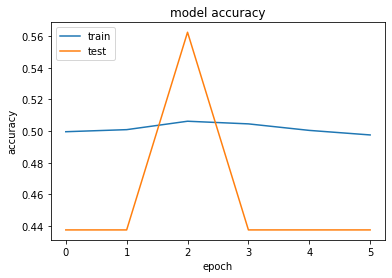

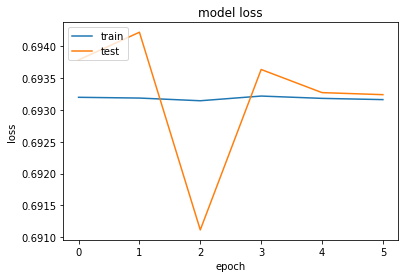

In [30]:
#PLOT for accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

NameError: name 'fpr_rf' is not defined

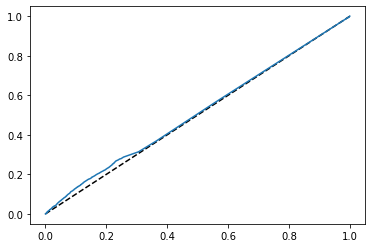

In [31]:
#Receiver Operating Characterstic (ROC) Curve for Model Evaluation
#Now, let's plot the ROC for both Random Forest Classifier & RNN with LSTM
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rnn,tpr_rnn,label='RNN(area={:.3f})'.format(auc_rnn))
plt.plot(fpr_rf,tpr_rf,label='Random Forest (area={:.3f})'.format(auc_rf))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Model Evaluation on unseen dataset
Model_evaluation=pd.DataFrame({'Model':['Random Forest Classifier','RNN with LSTM'],
                              'f1_score':[0.81,0.79],
                              'roc_auc_score':[np.round(auc_rf,3),np.round(auc_rnn,3)]})
Model_evaluation